In [1]:
# Import necessary libraries
import numpy as np
import os
from PIL import Image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [2]:


# Function to load and preprocess the dataset
def load_preprocessed_dataset(fname='elpv-dataset/labels.csv'):
    # Load the dataset
    data = np.genfromtxt(fname, dtype=['|S19', '<f8', '|S4'], names=['path', 'probability', 'type'])
    image_fnames = np.char.decode(data['path'])
    probs = data['probability']
    types = np.char.decode(data['type'])

    # Define a function to preprocess the images
    def load_and_preprocess_image(fname):
        with Image.open(fname) as image:
            # Preprocess image for ResNet50
            image = image.convert('RGB')
            image = image.resize((224, 224))
            image = np.array(image)
            image = preprocess_input(image)  # Use the imported function here
            return image

    # Load and preprocess images
    dir = os.path.dirname(fname)
    images = np.array([load_and_preprocess_image(os.path.join(dir, fn))
                       for fn in image_fnames])

    # Convert probabilities to categorical labels
    labels = to_categorical(np.round(probs * 3), num_classes=4)

    return images, labels, types

# Load and preprocess the dataset
images, labels, types = load_preprocessed_dataset()

# Split the dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Load the ResNet50 model pre-trained on ImageNet data
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the base model
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(1024, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/10
66/66 [==============================] - 50s 742ms/step - loss: 0.8577 - accuracy: 0.6779 - val_loss: 0.7416 - val_accuracy: 0.7162
Epoch 2/10
66/66 [==============================] - 45s 688ms/step - loss: 0.6945 - accuracy: 0.7418 - val_loss: 0.7057 - val_accuracy: 0.7371
Epoch 3/10
66/66 [==============================] - 43s 653ms/step - loss: 0.6551 - accuracy: 0.7480 - val_loss: 0.7071 - val_accuracy: 0.7371
Epoch 4/10
66/66 [==============================] - 44s 670ms/step - loss: 0.6164 - accuracy: 0.7632 - val_loss: 0.6934 - val_accuracy: 0.7505
Epoch 5/10
66/66 [==============================] - 75s 1s/step - loss: 0.5780 - accuracy: 0.7794 - val_loss: 0.6857 - val_accuracy: 0.7429
Epoch 6/10
66/66 [==============================] - 93s 1s/step - loss: 0.5664 - accuracy: 0.7942 - val_loss: 0.6622 - val_accuracy: 0.7657
Epoch 7/10
66/66 [==============================] - 93s 1s/step - loss: 0.5483 - accuracy: 0.7990 - val_loss: 0.6342 - val_accuracy: 0.7790
Epoch 8/

In [5]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Predict the test set results
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert y_test from one-hot encoding to class indices
y_test_classes = np.argmax(y_test, axis=1)

# Now calculate the confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)
print("Confusion Matrix:")
print(cm)

# Similarly, adjust the classification report
report = classification_report(y_test_classes, y_pred_classes, target_names=['Fully Functional', 'Possibly Defective', 'Likely Defective', 'Certainly Defective'])
print("\nClassification Report:")
print(report)



17/17 [==============================] - 9s 497ms/step
Confusion Matrix:
[[288   5   0  13]
 [ 42  11   0   5]
 [ 16   1   1   4]
 [ 28   4   0 107]]

Classification Report:
                     precision    recall  f1-score   support

   Fully Functional       0.77      0.94      0.85       306
 Possibly Defective       0.52      0.19      0.28        58
   Likely Defective       1.00      0.05      0.09        22
Certainly Defective       0.83      0.77      0.80       139

           accuracy                           0.78       525
          macro avg       0.78      0.49      0.50       525
       weighted avg       0.77      0.78      0.74       525



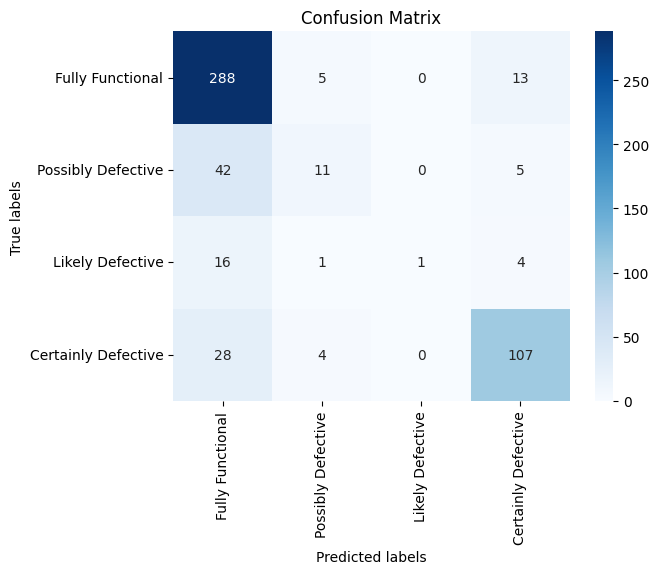

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Confusion Matrix
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Fully Functional', 'Possibly Defective', 'Likely Defective', 'Certainly Defective'], yticklabels=['Fully Functional', 'Possibly Defective', 'Likely Defective', 'Certainly Defective'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


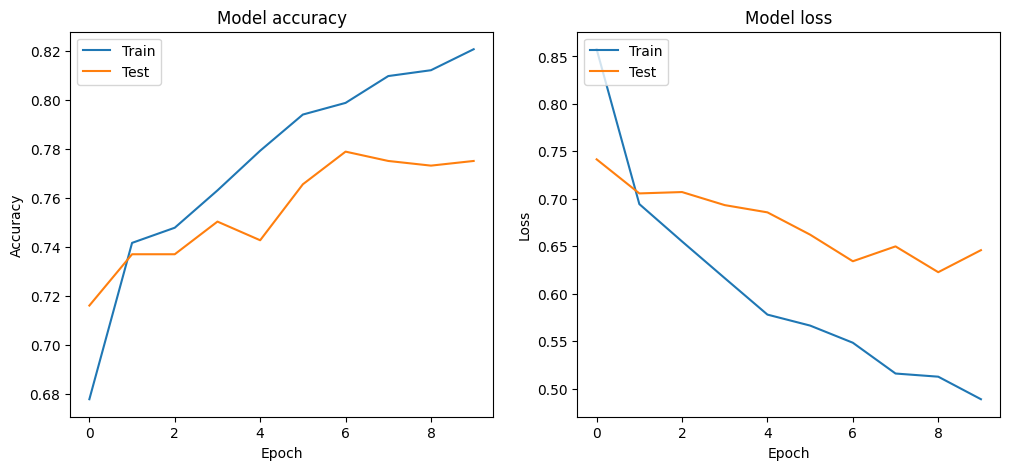

In [8]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


In [11]:
from sklearn.metrics import classification_report
import pandas as pd
# Convert y_test from one-hot encoding to class indices
y_test_classes = np.argmax(y_test, axis=1)

# Generate the classification report
report = classification_report(y_test_classes, y_pred_classes, target_names=['Fully Functional', 'Possibly Defective', 'Likely Defective', 'Certainly Defective'], output_dict=True)

# Convert to DataFrame
report_df = pd.DataFrame(report).transpose()

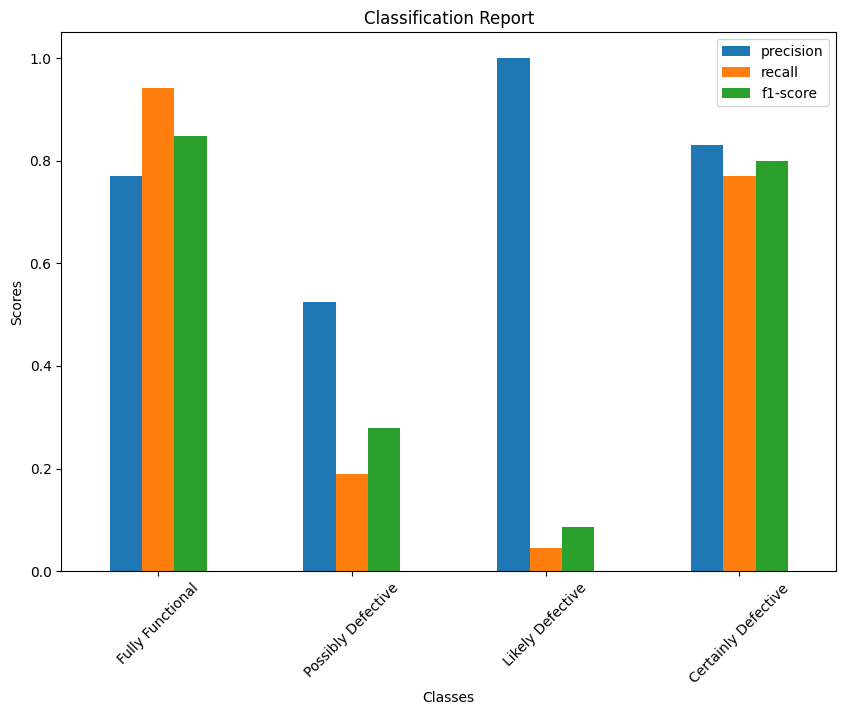

In [12]:
# Drop the support row
report_df = report_df.drop('support', axis=1)

# Plotting
report_df[:-3].plot(kind='bar', figsize=(10, 7))
plt.title('Classification Report')
plt.xlabel('Classes')
plt.ylabel('Scores')
plt.xticks(rotation=45)
plt.show()
